Многоканальную СМО с отказами и ограниченной очередью можно изобразить следующим графом: 

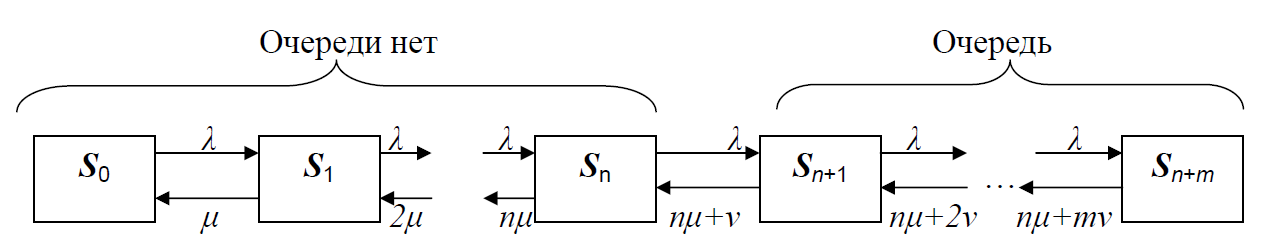

$$\lambda - интенсивность{\:}потока{\:}заявок\\
\mu - интенсивность{\:}потока{\:}обслуживания\\
\nu=\frac{1}{t_o} - интенсивность{\:}покидания{\:}очереди{\:} без {\:}обслуживания\\
n - число{\:}каналов\\
m - объём{\:}очереди\\
$$
Вышеуказанное равенство справедливо в виду того факта, что размер последовательноси событий, происходящих за время, распределённое по экспоненциальному закону, распределено по Пуассону (то есть данный поток также является простейшим).


Теоретические характеристики:  

Коэффициент загрузки

$$ρ=\frac{λ}{μ}\\ 
β=\frac{\nu}{\mu}
$$

Финальные вероятности

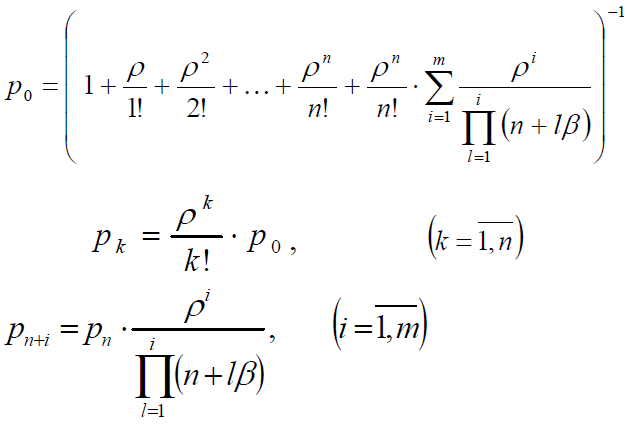

Абсолютная пропускная способность

$$A=λ(1-p_n\frac{\rho^m}{\prod^m_{l=1}(n+l\beta)})$$

Вероятность отказа

$$p_{отк}=\frac{\rho^m}{\prod^m_{l=1}(n+l\beta)}$$

Среднее число занятых каналов

$$L_{оч}=\sum^{n}_{k=1}{kp_k}+\sum^{m}_{k=1}{np_{n+1}}$$

Среднее число заявок в очереди

$$L_{оч}=p_n\sum^{m}_{i=1}{\frac{i\rho^i}{\prod^i_{l=1}(n+l\beta)}}$$

Среднее число заявок в СМО
$$L_{СМО}=L_{обс}+L{оч}$$

Среднее время пребывания заявки в очереди

$$t_{оч}=\frac{L{оч}}{λ}$$

Среднее время пребывания заявки в обслуживании

$$t_{обс}=\frac{L_{обс}}{\mu}$$

Реализуем метод моделирования, основанный на отсчёте времени. Для каждого состояния подсчитаем время, через которое произойдёт переход в каждое из доступных состояний по формуле $$Δt=-\frac{1}{i}ln{R},$$
где i -- интенсивность потока перехода, R -- случайная величина, равномерно распределённая на промежутке [0; 1]. После из всех найденных промежутков находим минимальный -- именно переход, соответствующий его потоку, считается реализованным и изменяет сотояние системы. Данное действие повторяется для нового состояния, ослеживая и сохраняя значения времени и самих состояний, чтобы потом использовать для получения эмпирических характеристик.

Поскольку мы используем подход моделирования, основанный на отсчёте времени, рассчитав время выхода системы из состояния n+m, мы начнём моделировать поток входящих заявок, рассчитывая, сколько за этот промежуток их придёт. Это значение является числом заявок, которым отказали в обслуживании за это время. 

In [10]:
import numpy as np
from math import log, factorial
import matplotlib.pyplot as mp

class Timeline:
    def __init__(self, time_step, L, M, N, n, m):
        self.time = 0
        self.time_step = time_step
        self.current_state = 0
        self.history = [0]
        self.disc_history = [0]
        self.L = L
        self.M = M
        self.N = N
        self.n = n
        self.m = m
        self.serve_count = 0

    def calculate_deltatime(self, intens):
        return - 1 / intens * log(np.random.uniform(0, 1))

    def progress(self, deltatime, statistics):
        self.time += deltatime
        occurences = int(deltatime / self.time_step)
        appendix = [self.current_state] * occurences
        statistics.state_history += appendix
        for _ in range(occurences):
            last_time = self.history[-1]
            self.history.append(last_time + self.time_step)
        self.disc_history.append(self.time)


class Statistics:
    def __init__(self):
        self.state_history = [0]
        self.total_count = 0
        self.disc_state_history = [0]
        self.reject_counts = 0


In [11]:
duration = 5000
L, M, N, n, m = 30, 1, 2, 5, 10
step = 0.01

timeline = Timeline(step, L, M, N, n, m)
statistics = Statistics()

print(f'Starting simulation with params lambda={L}, mu={M}, nu={N}, n={n}, m={m}')
print(f' for {duration} time units with step {step}')

while timeline.time < duration:
    if timeline.current_state == 0:
        delta_to_1 = timeline.calculate_deltatime(L)
        timeline.progress(delta_to_1, statistics)
        timeline.current_state += 1
        timeline.serve_count += 1
        statistics.total_count += 1
    elif timeline.current_state == n + m:
        delta_out = timeline.calculate_deltatime(n * M + m * N)
        timeline.progress(delta_out, statistics)
        timeline.current_state -= 1
        buffer_time = timeline.calculate_deltatime(L)
        while buffer_time < delta_out:
            statistics.reject_counts += 1
            statistics.total_count += 1
            buffer_time += timeline.calculate_deltatime(L)
    else:
        delta_in = timeline.calculate_deltatime(L)
        _m = timeline.current_state - n
        if _m < 0:
            _m = 0
        _n = timeline.current_state
        if _n > n:
            _n = n
        delta_out = timeline.calculate_deltatime(_n * M + _m * N)
        if delta_out >= delta_in:
            timeline.progress(delta_in, statistics)
            timeline.current_state += 1
            timeline.serve_count += 1
            statistics.total_count += 1
        else:
            timeline.progress(delta_out, statistics)
            timeline.current_state -= 1
    statistics.disc_state_history.append(timeline.current_state)

def partial(i):
    return np.prod([(n + (j + 1) * N / M) for j in range(i + 1)])

def count_occur(item, arr):
    count = 0
    for el in arr:
        if el == item:
            count += 1
    return count

Starting simulation with params lambda=30, mu=1, nu=2, n=5, m=10
 for 5000 time units with step 0.01


In [12]:
print()
print('Empirical characteristics:')
state_count = len(statistics.state_history)
fin_prob_emp = [count_occur(i, statistics.state_history) / state_count for i in range(n + m + 1)]
print(f'1) Final probabilities = {fin_prob_emp}')
print(f'2) Abs throughput = {timeline.serve_count / statistics.total_count * L}')
print(f'3) Reject probability = {statistics.reject_counts / statistics.total_count}')
avg_num_wt = sum([state if state <= n else n for state in statistics.state_history]) / len(statistics.state_history)
print(f'4) AVG number of working threads = {avg_num_wt}')
temp_states = []
for el in statistics.disc_state_history:
    if el >= n:
        temp_states.append(el - n)
avg_num_q = np.mean(temp_states)
print(f'5) AVG number of orders in queue = {avg_num_q}')
print(f'6) AVG number of orders in system = {avg_num_wt + avg_num_q}')
print(f'7) AVG queue time = {avg_num_q / L}')
print(f'8) AVG thread time = {(timeline.serve_count / statistics.total_count) / M}')
print()
print('Theoretical characteristics:')
p0 = 1 / (1 + (sum([(L / M) ** (i + 1) / factorial(i + 1) for i in range(n)])) + (L / M) ** n / factorial(n) *
          (sum([(L / M) ** (i + 1) / np.prod([(n + (j + 1) * N / M) for j in range(i + 1)]) for i in range(m)])))
p = [p0] + [p0 * (L / M) ** (i + 1) / factorial(i + 1) for i in range(n)] + [p0 * (L / M) ** n / factorial(n) * (L / M) ** (i + 1) / partial(i) for i in range(m)]
print(f'1) Final probabilities = {p}')
abs_throughput = L * (1 - p[n] * (L / M) ** m / np.prod([(n + (j + 1) * N / M) for j in range(m)]))
print(f'2) Abs throughput = {abs_throughput}')
rej_prob = p[n + m]
print(f'3) Reject probability = {rej_prob}')
avg_num_wt = sum([(i + 1) * p[i + 1] for i in range(n)]) + sum(n * p[n + i + 1] for i in range(m))
print(f'4) AVG number of working threads = {avg_num_wt}')
avg_num_q = p[n] * sum([(i + 1) * (L / M) ** (i + 1) /
                                 np.prod([(n + (j + 1) * N / M) for j in range(i + 1)]) for i in range(m)])
print(f'5) AVG number of orders in queue = {avg_num_q}')
print(f'6) AVG number of orders in system = {avg_num_wt + avg_num_q}')
print(f'7) AVG queue time = {avg_num_q / L}')
print(f'8) AVG thread time = {(1 - p[n] * (L / M) ** m / np.prod([(n + (j + 1) * N / M) for j in range(m)])) / M}')



Empirical characteristics:
1) Final probabilities = [1.4949619781336894e-05, 4.983206593778965e-06, 7.474809890668447e-06, 0.0, 4.983206593778965e-05, 0.0002092946769387165, 0.0012931421110856413, 0.00361033317719286, 0.010624196457936753, 0.023712588576497204, 0.04384723481866111, 0.07901372375095926, 0.12443814345655142, 0.17434495749324774, 0.22496935327944825, 0.3138597924992774]
2) Abs throughput = 21.44737719567334
3) Reject probability = 0.28508742681088867
4) AVG number of working threads = 4.999833062579109
5) AVG number of orders in queue = 7.989668120437531
6) AVG number of orders in system = 12.989501183016639
7) AVG queue time = 0.266322270681251
8) AVG thread time = 0.7149125731891113

Theoretical characteristics:
1) Final probabilities = [1.2608589337494368e-09, 3.7825768012483105e-08, 5.673865201872466e-07, 5.673865201872465e-06, 4.255398901404349e-05, 0.00025532393408426096, 0.00109424543178969, 0.003647484772632299, 0.009947685743542635, 0.022956197869713774, 0.04591

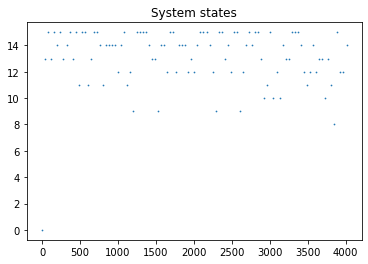

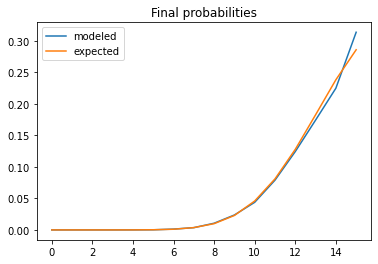

In [13]:
mp.title('System states')
mp.scatter(timeline.history[::(len(timeline.history) // 100)],
           statistics.state_history[::(len(timeline.history) // 100)], s=0.5)
mp.show()

mp.title('Final probabilities')
mp.plot(list(range(n + m + 1)), fin_prob_emp)
mp.plot(list(range(n + m + 1)), p)
mp.legend(['modeled', 'expected'])
mp.show()